In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [18]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [20]:
MC = inspector.get_columns('measurement')
for x in MC:
    print(x['name'], x["type"])
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")    
SC = inspector.get_columns('station')
for y in SC:
    print(y['name'], y["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
M=Base.classes.measurement
S=Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [127]:
# Calculate the date 1 year ago from the last data point in the database
LDP = session.query(M.date).\
        order_by(M.date.desc()).first()
LDP

('2017-08-23')

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
FDP = (dt.datetime.strptime(LDP[0],'%Y-%m-%d')-dt.timedelta(days=365)).strftime('%Y-%m-%d')
FDP

'2016-08-23'

In [24]:
# Perform a query to retrieve the data an precipitation scores
pscores = session.query(M.date,M.prcp).\
            filter(M.date >= FDP).all()
pscores[:4]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0)]

In [111]:
# Save the query results as a Pandas DataFrame and set the index to the date column
pscores2=pd.DataFrame(pscores,columns=['Date','Percipitation'])
pscores2

,Date,Percipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [112]:
# Sort the dataframe by date
pscores2.set_index('Date', inplace=True)
pscores2 = pscores2.sort_index(ascending = True)
pscores2

,Percipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<Figure size 1008x720 with 0 Axes>

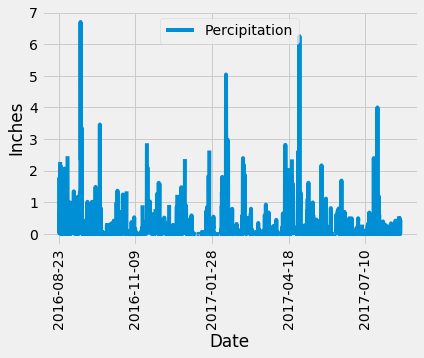

<Figure size 1008x720 with 0 Axes>

In [116]:
# Use Pandas Plotting with Matplotlib to plot the data
plot = pscores2.plot(rot=90);
plot.set_ylabel("Inches")
plt.figure(figsize=(14,10))


In [117]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pscores2.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [118]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(S.id)).all()
stations

[(9)]

In [128]:
# What are the most active stations? (i.e. what stations have the most rows)?
Dataperstation =session.query(M.station, func.count(M.station)).\
                    group_by(M.station).\
                        order_by(func.count(M.station).desc()).all()
# List the stations and the counts in descending order.
Dataperstation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [153]:
# Choose the station with the highest number of temperature observations.
stationsactivity = session.query(M.station).group_by(M.station).\
                order_by(func.count(M.date).desc()).first()
mostactive = stationsactivity[0]
mostactive

'USC00519281'

In [154]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowesttempobs = session.query(func.min(M.tobs)).\
                    filter(M.station=='USC00519281').all()
lowesttempobs

[(54.0)]

In [155]:
# highest temperature recorded, 
highesttempobs = session.query(func.max(M.tobs)).\
                    filter(M.station=='USC00519281').all()
highesttempobs


[(85.0)]

In [156]:
#and average temperature of the most active station?
averagetempobs=session.query(func.avg(M.tobs)).\
                    filter(M.station=='USC00519281').all()
averagetempobs

[(71.66378066378067)]

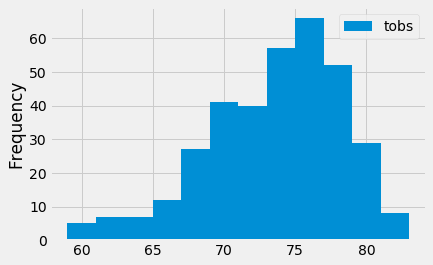

In [163]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

maxstationtobs = session.query(M.tobs, M.date).filter(M.date > '2016-08-23',
    M.station.contains('USC00519281')).all()
maxdf=pd.DataFrame(maxstationtobs, columns=['tobs','date'])
maxdf.plot.hist(bins=12)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
